<a href="https://colab.research.google.com/github/rrankawat/pytorch-wildfire-detection/blob/main/wildfire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN-Based Generation and Deep Learning for Wildfire Detection**

### **Introduction**

Wildfires pose a significant threat to natural ecosystems, human lives, and property. Effective and timely detection of wildfires is crucial for minimizing damage and ensuring safety. This project focuses on two main objectives: generating synthetic wildfire images using Generative Adversarial Networks (GANs) and developing a deep learning-based system for wildfire detection through image segmentation and classification.

### **Objective**

1. **GAN-Based Generation of Wildfire Smoke:**

  *   Generate realistic images of wildfire smoke using a GAN.
  *   Enhance the dataset with synthetic images to improve the performance of the detection model.

2. **Deep Learning for Wildfire Detection:**

  *   Develop a deep learning model to accurately classify images as fire or no fire.
  *   Implement segmentation techniques to localize fire regions within an image.

### **Methodology**

1. **GAN-Based Image Generation**

  * **Generator:** A neural network that generates synthetic images of fire or no fire from random noise and labels.
  * **Discriminator:** A neural network that distinguishes between real images from the dataset and synthetic images generated by the Generator.
  * **Training:** The Generator and Discriminator are trained in an adversarial manner. The Generator tries to create realistic images to fool the Discriminator, while the Discriminator learns to better identify real versus fake images.

2. **Deep Learning for Detection**

  * **Model Architecture:** A Convolutional Neural Network (CNN) designed for binary classification (fire vs. no fire).
  * **Training:** The CNN is trained using the labeled dataset of fire and no fire images. The dataset is split into training and validation sets to monitor the model’s performance and avoid overfitting.
  * **Evaluation Metrics:** The model’s performance is evaluated using accuracy, precision, recall, and F1 score to ensure it effectively detects fires.

### **Results**

* **GAN Training:** The GAN successfully generates realistic images of wildfire smoke, which can be used to augment the training dataset.
* **Classifier Performance:** The CNN classifier achieves high accuracy, precision, recall, and F1 score, indicating effective detection of fire in images.

### **Future Work**

* **Dataset Expansion:** Incorporate more diverse images to improve the model’s robustness.
* **Advanced Segmentation:** Implement more sophisticated segmentation techniques to precisely localize fire regions within images.
* **Real-Time Detection:** Develop real-time detection capabilities for deployment in surveillance systems.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Step 1: Data Preparation**

**Description:** Prepare the dataset so it can be used for training our models. The dataset consists of two folders: one containing images of fire and another with images without fire.


In [2]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class WildfireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.fire_images = [os.path.join(root_dir, 'fire_images', f) for f in os.listdir(os.path.join(root_dir, 'fire_images'))]
        self.no_fire_images = [os.path.join(root_dir, 'no_fire_images', f) for f in os.listdir(os.path.join(root_dir, 'no_fire_images'))]
        self.all_images = self.fire_images + self.no_fire_images
        self.labels = [1] * len(self.fire_images) + [0] * len(self.no_fire_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = WildfireDataset('/content/drive/MyDrive/wildfire_dataset/', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### **Step 2: GAN Model**

**Description:** Define the Generator and Discriminator models for the GAN. The Generator creates fake images of fire or no fire, and the Discriminator tries to distinguish between real and fake images.

In [5]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, label_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(2, label_dim)
        self.model = nn.Sequential(
            nn.Linear(z_dim + label_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embeddings = self.label_embedding(labels)
        gen_input = torch.cat((z, label_embeddings), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 3, 128, 128)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(2, label_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embeddings = self.label_embedding(labels)
        d_in = torch.cat((img.view(img.size(0), -1), label_embeddings), -1)
        validity = self.model(d_in)
        return validity

### **Step 3: Training the GAN**

**Description:** The Generator tries to create realistic images to fool the Discriminator, while the Discriminator tries to get better at distinguishing real images from fake ones.

In [14]:
import torch.optim as optim

z_dim = 100
img_dim = 128 * 128 * 3
label_dim = 10

device = torch.device('cpu')

generator = Generator(z_dim, img_dim, label_dim).to(device)
discriminator = Discriminator(img_dim, label_dim).to(device)

adversarial_loss = nn.BCELoss().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 200

# Track losses
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for imgs, labels in dataloader:
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, 2, (batch_size,)).to(device)

        gen_imgs = generator(z, gen_labels)

        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item()}, loss G: {g_loss.item()}')

Epoch [10/200]  Loss D: 0.3840246796607971, loss G: 0.6280636787414551
Epoch [20/200]  Loss D: 0.6994540095329285, loss G: 1.8125934600830078
Epoch [30/200]  Loss D: 0.1947219967842102, loss G: 1.1678496599197388
Epoch [40/200]  Loss D: 0.10957365483045578, loss G: 1.6676753759384155
Epoch [50/200]  Loss D: 0.11469873040914536, loss G: 1.7101757526397705
Epoch [60/200]  Loss D: 0.05998421460390091, loss G: 2.3515918254852295
Epoch [70/200]  Loss D: 0.505905270576477, loss G: 0.6931139826774597
Epoch [80/200]  Loss D: 0.1436634063720703, loss G: 1.5121943950653076
Epoch [90/200]  Loss D: 0.25087597966194153, loss G: 0.9652031064033508
Epoch [100/200]  Loss D: 0.12423884868621826, loss G: 2.0515589714050293
Epoch [110/200]  Loss D: 0.14611925184726715, loss G: 1.4467910528182983
Epoch [120/200]  Loss D: 0.10702452808618546, loss G: 1.807826042175293
Epoch [130/200]  Loss D: 0.09084998816251755, loss G: 2.23567795753479
Epoch [140/200]  Loss D: 0.11391487717628479, loss G: 2.3558564186096

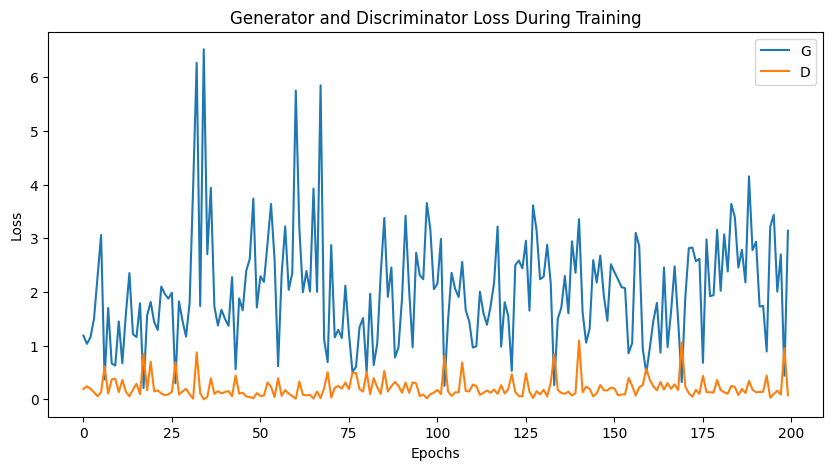

In [15]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **Step 4: Deep Learning Model for Classification**

**Description:** We define a CNN-based model to classify images as either fire or no fire. This model learns to recognize patterns associated with fire and no fire images.

In [16]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = CNNClassifier().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### **Step 5: Training the Classifier**

**Description:** Train the CNN classifier on the labeled dataset. We monitor the training and validation loss to ensure the model is learning effectively.

In [17]:
# Initialize lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(dataloader.dataset)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(dataloader.dataset)
    val_accuracy = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/25]  Train Loss: 0.6910, Val Loss: 0.6727, Train Acc: 0.5925, Val Acc: 0.7275
Epoch [2/25]  Train Loss: 0.6509, Val Loss: 0.6108, Train Acc: 0.8075, Val Acc: 0.7350
Epoch [3/25]  Train Loss: 0.5728, Val Loss: 0.5004, Train Acc: 0.7600, Val Acc: 0.8500
Epoch [4/25]  Train Loss: 0.4536, Val Loss: 0.3791, Train Acc: 0.8550, Val Acc: 0.8800
Epoch [5/25]  Train Loss: 0.3556, Val Loss: 0.3092, Train Acc: 0.8800, Val Acc: 0.8900
Epoch [6/25]  Train Loss: 0.2933, Val Loss: 0.2666, Train Acc: 0.8950, Val Acc: 0.9150
Epoch [7/25]  Train Loss: 0.2587, Val Loss: 0.2430, Train Acc: 0.9100, Val Acc: 0.9150
Epoch [8/25]  Train Loss: 0.2423, Val Loss: 0.2298, Train Acc: 0.9125, Val Acc: 0.9175
Epoch [9/25]  Train Loss: 0.2195, Val Loss: 0.2913, Train Acc: 0.9175, Val Acc: 0.8675
Epoch [10/25]  Train Loss: 0.2512, Val Loss: 0.2711, Train Acc: 0.9025, Val Acc: 0.8875
Epoch [11/25]  Train Loss: 0.2251, Val Loss: 0.2626, Train Acc: 0.9125, Val Acc: 0.8875
Epoch [12/25]  Train Loss: 0.2180, Val Lo

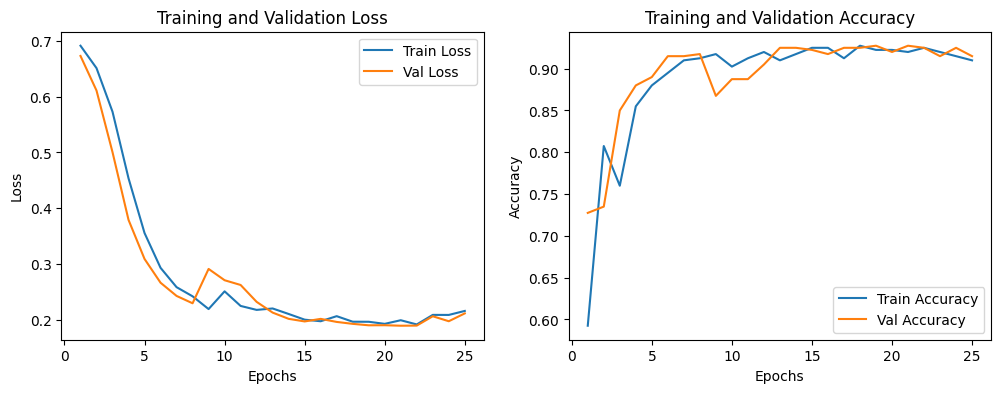

In [18]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

### **Step 6: Evaluation**

**Description:** Evaluate the trained model using metrics such as accuracy, precision, recall, and F1 score.

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(imgs)
        preds = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Accuracy: 0.9150, Precision: 0.8807, Recall: 0.9600, F1 Score: 0.9187


In [20]:
from PIL import Image

# Define a function to preprocess images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Example of loading and preprocessing an image
image_path = '/content/drive/MyDrive/wildfire_dataset/test/fire_0512.jpg'
test_image = preprocess_image(image_path)

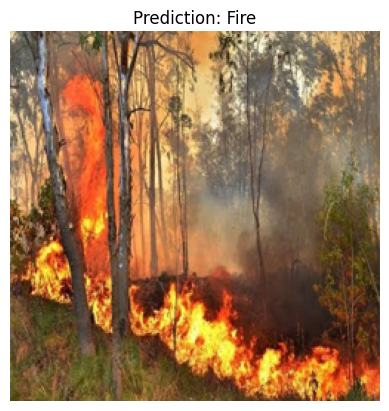

In [21]:
import matplotlib.pyplot as plt

# Define a function to predict and visualize the result
def predict_and_visualize(model, image_path):
    model.eval()
    image = preprocess_image(image_path).to(device)
    output = model(image)
    prediction = (output > 0.5).float().item()

    # Display the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Prediction: {"Fire" if prediction == 1 else "No Fire"}')
    plt.axis('off')
    plt.show()

# Example of predicting and visualizing a test image
image_path = '/content/drive/MyDrive/wildfire_dataset/test/fire_0512.jpg'
predict_and_visualize(model, image_path)

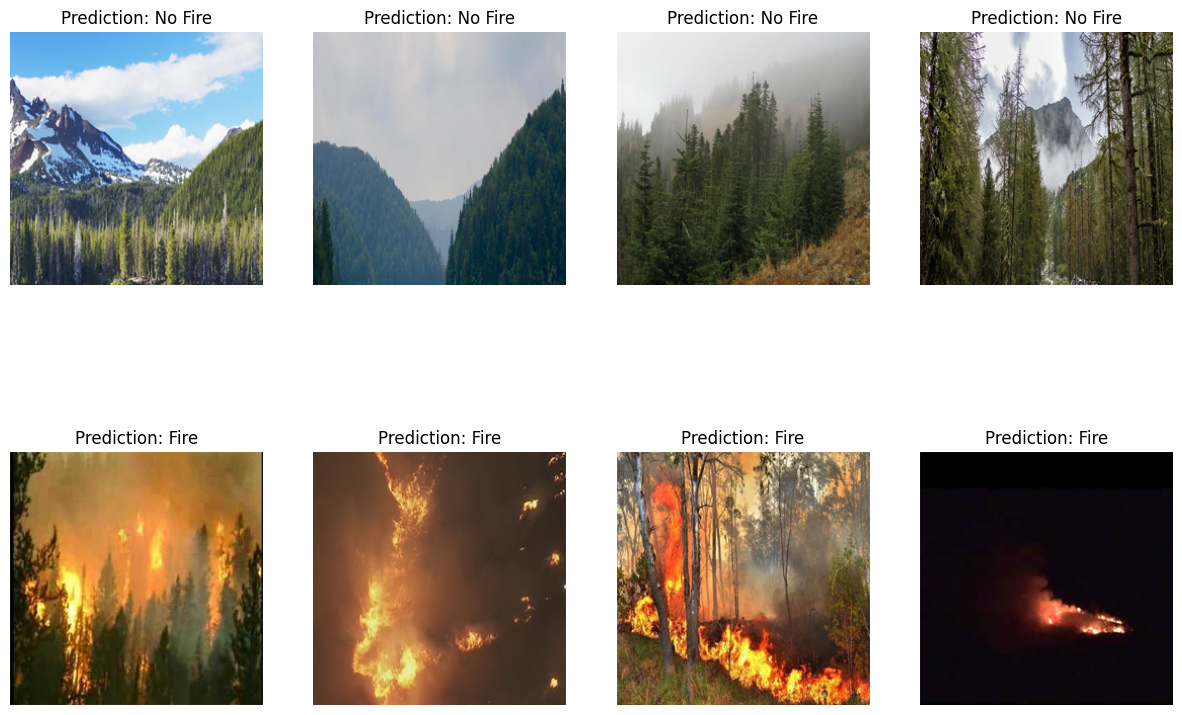

In [33]:
def predict_and_visualize_batch(model, image_paths):
    model.eval()
    images = [preprocess_image(image_path) for image_path in image_paths]
    images = torch.cat(images).to(device)

    outputs = model(images)
    predictions = (outputs > 0.5).float().cpu().numpy()

    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path).convert('RGB')
        plt.subplot(2, len(image_paths)//2, i+1)
        plt.imshow(image)
        plt.title(f'Prediction: {"Fire" if predictions[i] == 1 else "No Fire"}')
        plt.axis('off')
    plt.show()

# Example of predicting and visualizing a batch of test images
image_paths = [
    '/content/drive/MyDrive/wildfire_dataset/test/nofire_0354.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/nofire_0365.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/nofire_0370.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/nofire_0405.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/fire_0516.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/fire_0522.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/fire_0512.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/fire_0525.jpg',
]
predict_and_visualize_batch(model, image_paths)